In [1]:
"""
This project takes in the MNIST training dataset and does stuff
"""

import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
# import torch;

train_df = pd.read_csv('digit-recognizer/train.csv')

train_labels = train_df['label']
train_df.drop(['label'],inplace=True, axis=1)

np_train = train_df.to_numpy()

In [2]:
print(np.shape(np_train[0])) # this is the shape for each entry in the training dataframe

(784,)


In [3]:
filename = 'training_data.p'

### loading the data if it's been previously generated ###
try:
    infile = open(filename,'rb')
    train_input = pickle.load(infile)
    infile.close()

### Generating and saving the data ###
except:
    two_d = np.reshape(np_train[0],[1,28,28])
    train_input = two_d

    for ind in tqdm(range(1,np.shape(np_train)[0])):
    #     if ind == 10:
    #         break
        two_d = np.reshape(np_train[ind],[1,28,28])
        train_input = np.concatenate((train_input, two_d), axis = 0)

    print(np.shape(train_input))

    outfile = open(filename,'wb')
    pickle.dump(train_input, outfile)
    outfile.close()

    print('saved successfully!')

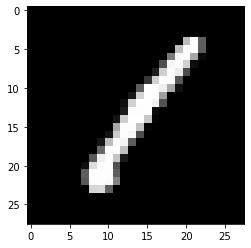

In [4]:
from matplotlib import pyplot as plt
plt.imshow(train_input[0], cmap='gray')

In [8]:
X_train, X_test, y_train, y_test = train_test_split(train_input, train_labels, test_size=0.20, random_state=42)

In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F



class Net(nn.Module):
    
    """
    from https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html
    """

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 5) #in channels, out channels (AKA # of kernels), kernel size
        self.conv2 = nn.Conv2d(6, 16, 5) 
        # an affine operation: y = Wx + b
        #self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 5*5 from image dimension
        self.fc1 = nn.Linear(16 * 4 * 4, 120) # 4*4 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
#         x = F.max_pool2d(F.leaky_relu(self.conv1(x), 0.01), (2, 2)) #trying with leaky
        # If the size is a square, you can specify with a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
#         x = F.max_pool2d(F.leaky_relu(self.conv2(x), 0.01), 2) #trying with leaky
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
#         x = F.leaky_relu(self.fc1(x), 0.01)
#         x = F.leaky_relu(self.fc2(x), 0.01)
        x = self.fc3(x)
        return x

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [40]:
params = list(net.parameters())
print(len(params))
print(params[0].size())

10
torch.Size([6, 1, 5, 5])


In [44]:
input = torch.randn(1, 1, 28, 28)
#input = torch.randn(28, 28)
out = net(input)
print(out)

tensor([[-0.0069,  0.0406, -0.1498, -0.0071,  0.0430, -0.0599,  0.0194,  0.0951,
         -0.1409, -0.0665]], grad_fn=<AddmmBackward>)


In [45]:
net.zero_grad()
out.backward(torch.randn(1, 10))

In [46]:
output = net(input)
target = torch.randn(10)  # a dummy target, for example
target = target.view(1, -1)  # make it the same shape as output
criterion = nn.MSELoss()

loss = criterion(output, target)
print(loss)

tensor(0.8366, grad_fn=<MseLossBackward>)


In [47]:
net.zero_grad()     # zeroes the gradient buffers of all parameters

print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)

loss.backward()

print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)

conv1.bias.grad before backward
tensor([0., 0., 0., 0., 0., 0.])
conv1.bias.grad after backward
tensor([-0.0084, -0.0294, -0.0020, -0.0164,  0.0121,  0.0048])


In [48]:
learning_rate = 0.01
for f in net.parameters():
    f.data.sub_(f.grad.data * learning_rate)

In [50]:
np.shape(X_train)

(33600, 28, 28)

In [51]:
np.shape(y_train)

(33600,)

In [52]:
import torch.optim as optim

# create your optimizer
optimizer = optim.SGD(net.parameters(), lr=0.01)

# # in your training loop:
# optimizer.zero_grad()   # zero the gradient buffers
# output = net(input)
# loss = criterion(output, target)
# loss.backward()
# optimizer.step()  
    
for idx in range(np.shape(X_train)[0]): # from https://pytorch.org/tutorials/beginner/pytorch_with_examples.html
    # Forward pass: compute predicted y by passing x to the model.
    x_val = torch.tensor(X_train[idx])
    y_pred = net(x_val)

    # Compute and print loss.
    loss = loss_fn(y_pred, y_train[idx])
    if t % 100 == 99:
        print(t, loss.item())

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable
    # weights of the model). This is because by default, gradients are
    # accumulated in buffers( i.e, not overwritten) whenever .backward()
    # is called. Checkout docs of torch.autograd.backward for more details.
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()
    
linear_layer = net[0]
print(f'Result: y = {linear_layer.bias.item()} + {linear_layer.weight[:, 0].item()} x + {linear_layer.weight[:, 1].item()} x^2 + {linear_layer.weight[:, 2].item()} x^3')



torch.Size([28, 28])


RuntimeError: Expected 4-dimensional input for 4-dimensional weight [6, 1, 5, 5], but got 2-dimensional input of size [28, 28] instead